In [326]:
import dns.query
import dns.message
import re
import ipaddress
import time
import datetime
import random
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
cache = {}

In [4]:
root_servers = {}

root_servers['a'] = '198.41.0.4'
root_servers['b'] = '199.9.14.201'
root_servers['c'] = '192.33.4.12'
root_servers['d'] = '199.7.91.13'
root_servers['e'] = '192.203.230.10'
root_servers['f'] = '192.5.5.241'
root_servers['g'] = '192.112.36.4'
root_servers['h'] = '198.97.190.53'
root_servers['i'] = '192.36.148.17'
root_servers['j'] = '192.58.128.30'
root_servers['k'] = '193.0.14.129'
root_servers['l'] = '199.7.83.42'
root_servers['n'] = '202.12.27.33'

In [5]:
def output(hostname, rdtype, myresponse, elapsed, cnames):
    '''The output of the program
    
    Args:
        hostname (str): host to be queried
        rdtype (str): type A, NS, or MX
        myresponse (dns.message.Message): reponse from the DNS query
        elapsed (float): time elapsed
        cnames (list): cnames during a dns query
    '''
    
    answers = []
    for rrset in myresponse.answer:
        for item in rrset.items:
            answers.append(item.to_text())
            
    hostname_ = hostname + '.'
    
    number = str(30)
    for answer in answers:
        re_number = '(\d+)(.*)' + answers[0]
        match = re.search(re_number, myresponse.to_text())
        if match:
            number = match.group(1)
        number = str(number)
        break
    
    
    first_line = 'QUESTION SECTION:\n'
    second_line = hostname_.ljust(39) + 'IN'.ljust(5) + rdtype.ljust(5) + '\n\n'
    third_line = 'ANSWER SECTION:\n'
    forth_line = ''
    
    if len(cnames) > 0:
        left = hostname_
        for cname in cnames:
            forth_line = forth_line + left.ljust(33) + number.ljust(6) + 'IN'.ljust(5) + 'CNAME'.ljust(7) + cname + '\n'
            left = cname
        for answer in answers:
            forth_line = forth_line + left.ljust(33) + number.ljust(6) + 'IN'.ljust(5) + rdtype.ljust(7) + answer + '\n'
    else:    
        for answer in answers:
            forth_line = forth_line + hostname_.ljust(33) + number.ljust(6) + 'IN'.ljust(5) + rdtype.ljust(7) + answer + '\n'
    
    string = first_line + second_line + third_line + forth_line
    
    print('\n')
    print(string)
    
    cache[hostname + ' ' + rdtype] = string  # insert into global cache
    
    msg_size = str(len(string.replace(' ', '')))
    print('Query time: ' + str(int(elapsed * 1000)) + ' msec')
    print('WHEN:', datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y"))
    print('MSG SIZE rcvd: ', msg_size, '\n')

In [6]:
def output_sec(hostname, rdtype, response, elapsed, cnames):
    '''The output of the program
    
    Args:
        hostname (str): host to be queried
        rdtype (str): type A, NS, or MX
        myresponse (dns.message.Message): reponse from the DNS query
        elapsed (float): time elapsed
        cnames (list): cnames during a dns query
    '''
  
    print('\n', 'QUESTION:')
    for i in response.question:
        print(i.to_text())
    
    print('\n', 'ANSWER:')
    for i in response.answer:
        print(i.to_text())
        
    print('\n')
    
    msg_size = str(len(myresponse.to_text()))
    print('Query time: ' + str(int(elapsed * 1000)) + ' msec')
    print('WHEN:', datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y"))
    print('MSG SIZE rcvd: ', msg_size, '\n')

In [7]:
def output_cache(string, elapsed):
    print(string)
    msg_size = len(string.replace(' ', ''))
    print('Query time: ' + str(int(elapsed * 1000)) + ' msec')
    print('WHEN:', datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y"))
    print('MSG SIZE rcvd: ', msg_size)

In [8]:
def get_cname_from_rrset(rrset):
    '''Get CNAME from a RRset (from ANSWER section)
    
    Args:
        rrset (A DNS RRset): contains an CNAME to be extracted
        
    Returns:
        CNAME (str): the CNAME in the RRset
    '''
    try:
        item = rrset.items[0]
        return item.to_text()
    except Exception as e:
        print('Oops! Some issue with cname: ', e)

In [9]:
def get_ip_from_rrset(rrset):
    ''' Get IP address from a RRset (from ADDITIONAL section)
    
    Args:
        rrset (A DNS RRset ): contains an IP address to be extracted
        
    Return:
        ip (str): the IP address in the RRset
    '''
    try:
        item = rrset.items[0]
        return item.to_text()
    except Exception as e:
        print('Oops! Some issue with ip: ', e)

In [10]:
def get_ns_from_authority(response):
    '''Get a name server from AUTHORITY.
    In some cases, there is no ADDITIONAL section, just AUTHORITY section!
    
    Args:
        response (dns.message.Message)
        
    Return:
        string: A name of ns server
    '''
    rrsets = response.authority[0].items
    index = random.randint(0, len(rrsets)-1)
    return rrsets[index].to_text()

In [11]:
def check_hostname(hostname):
    '''Check whether a host is valid.
    
    Args:
        hostname (str): a hostname
        
    Return:
        True or False
    '''
    re_domain = '^(?=.{4,255}$)([a-zA-Z0-9][a-zA-Z0-9-]{,61}[a-zA-Z0-9]\.)+[a-zA-Z0-9]{2,5}.$'
    match = re.match(re_domain, hostname)
    if match:
        return True
    else:
        return False

In [169]:
def single_iterate(hostname, rdtype, where, timeout=1, dnssec=False):
    ''' A single iterative DNS query
    
    Args:
        hostname (str): host to be queried
        rdtype (str): type A, NS, or MX
        where (str):  IP address of query destination
        dnssec (bool): whether use DNSSEC protocal or not
    Return: 
        response (dns.message.Message): the response of a single query
        
    Exception:
        May raise an exception
    '''
    a_query = dns.message.make_query(hostname, rdtype, want_dnssec=dnssec)
    try:
        #print('single iterate: ', hostname, rdtype, where)
        response = dns.query.udp(a_query, where, timeout)
        return response
    except Exception as e:
        raise e  # Let the block who call this function catch the exception

In [13]:
def check_response(response, rdtype):
    '''Check whether the response has a valid IP address in its ANSWER section.
    
    Args:
        response (dns.message.Message): the response of a single query
        rdtype (str): type A=1, NS=2, CNAME=5, MX=15
    
    Return:
        True or False
    '''
    try:
        if rdtype == 'A':
            ip = get_ip_from_rrset(response.answer[0])
            ipaddress.ip_address(ip)
            return True
        elif rdtype == 'NS':                           # return NS when 'dig cnn.com NS'
            answer_type = response.answer[0].rdtype    # return all the CNAMEs when 'dig www.cnn.com NS'
            if answer_type == 2:
                return True                            # if NS, then return the answer
            elif answer_type == 5:
                return False                           # if CNAME, then keep looking for its NS
            else:
                return False                           # not sure if this condtion exist
        elif rdtype == 'MX':
            answer_type = response.answer[0].rdtype    # if MX, then return the answer
            if answer_type == 15:
                return True
            elif answer_type == 5:                     # if CNAME, then keep looking for its MX
                return False
            else:
                return False                           # not sure if this condtion exist
    except Exception as e:
        return False            

In [14]:
def dns_resolver(hostname, rdtype):
    ''' My DNS resolver version 0.1
    
    Args:
        hostname (str): target hostname
        rdtype (str):   type A, NS, or MX
        cnames (list):  a list of CNAMES during a dns query
        
    Return:
        response (dns.message.Message): response of this dns query
    '''
    for root in root_servers.values():
        response = single_iterate(hostname, rdtype, root)
        if len(response.additional) == 0:
            continue                     # root doesn't have top level domain information
        while(len(response.answer)==0):  # answer section is empty, then keep interating
            for rrset in response.additional:
                next_ip = get_ip_from_rrset(rrset)
                response = single_iterate(hostname, rdtype, next_ip)
                if len(response.answer)!=0 or len(response.additional)!=0: # if exist answer or exist additional, then the iterate is good
                    break  # if both no answer and no additional, then iterate agian using another ip
        if check_response(response): # ip is in the response
            return response
        else:                         # CNAME is in the response
            for rrset in response.answer:
                cname = get_cname_from_rrset(rrset)
                print(cname)
                return dns_resolver(cname, rdtype)

In [15]:
def dns_resolver_2(hostname, rdtype, cnames):
    ''' My DNS resolver version 0.2
    
    Args:
        hostname (str): target hostname
        rdtype (str):   type A, NS, or MX
        cnames (list):  a list of CNAMES during a dns query
        
    Return:
        response (dns.message.Message): response of this dns query
    '''
    for root in root_servers.values():
        try:
            response = single_iterate(hostname, rdtype, root, timeout=1)
            if len(response.additional) == 0:
                continue                           # root doesn't have top level domain information
            while(len(response.answer)==0 ):       # if ANSWER section is empty, then keep iterating
                if len(response.additional) > 0:   # use the IP in ADDITIONAL section
                    for rrset in response.additional:
                        next_ip = get_ip_from_rrset(rrset)
                        try:
                            response2 = single_iterate(hostname, rdtype, next_ip, timeout=1)
                            response = response2
                            break
                        except Exception as e:
                            pass  # print('Oops! Authoratative server timeout, try next one. ', e)
                else:             # if both ANSWER and ADDITIONAL is empty, then find the IP of AUTHORITY  
                    ns = get_ns_from_authority(response)
                    response2 = dns_resolver_2(ns, rdtype, cnames)
                    authority_answer = response2.answer[0]
                    response.additional.append(authority_answer)  # add rrset that contains IP of a AUTHORITY to response
            if check_response(response):  # ip is in the response
                return response
            else:                         # CNAME is in the response
                for rrset in response.answer:
                    cname = get_cname_from_rrset(rrset)
                    cnames.append(cname)
                    return dns_resolver_2(cname, rdtype, cnames)
            break
        except Exception as e:
            pass   # print('Oops! Some error, start from a new root server.', e)

In [31]:
def dns_resolver_3(hostname, rdtype, cnames):
    ''' My DNS resolver version 0.3
    
    Args:
        hostname (str): target hostname
        rdtype (str):   type A, NS, or MX
        cnames (list):  a list of CNAMES during a dns query
        
    Return:
        response (dns.message.Message): response of this dns query
    '''
    for root in root_servers.values():
        try:
            print(hostname, rdtype, root)
            response = single_iterate(hostname, rdtype, root, timeout=0.5)
            if len(response.additional) == 0:
                continue                           # root doesn't have top level domain information
            while(len(response.answer)==0 ):       # if ANSWER section is empty, then keep iterating
                if len(response.additional) > 0:   # use the IP in ADDITIONAL section
                    for rrset in response.additional:
                        next_ip = get_ip_from_rrset(rrset)
                        try:
                            response2 = single_iterate(hostname, rdtype, next_ip, timeout=0.5)
                            response = response2
                            break
                        except Exception as e:
                            pass  # print('Oops! Authoratative server timeout, try next one. ', e)
                else:             # if both ANSWER and ADDITIONAL is empty, then find the IP of AUTHORITY  
                    ns = get_ns_from_authority(response)
                    if check_hostname(ns):
                        response2 = dns_resolver_3(ns, 'A', cnames)
                        authority_answer = response2.answer[0]
                        response.additional.append(authority_answer)  # add rrset that contains IP of a AUTHORITY to response
                    else:
                         return response   # hostname in AUTHORITY is not valid
            #print('check response-1')
            if check_response(response, rdtype):  # ip is in the response
                #print('check response-2')
                return response
            else:                         # CNAME is in the response
                for rrset in response.answer:
                    cname = get_cname_from_rrset(rrset)
                    cnames.append(cname)
                    return dns_resolver_3(cname, rdtype, cnames)
            break
        except Exception as e:
            print(e)   # print('Oops! Some error, start from a new root server.', e)

In [41]:
# non-cache version

hostname = 'www.cnn.com'
rdtype = 'A'
cnames = []

start = time.time()

myresponse = dns_resolver_3(hostname, rdtype, cnames)

elapsed = time.time() - start

output(hostname, rdtype, myresponse, elapsed, cnames)

single iterate:  www.cnn.com A 198.41.0.4
single iterate:  www.cnn.com A 192.12.94.30
single iterate:  www.cnn.com A 205.251.192.47
single iterate:  turner-tls.map.fastly.net. A 198.41.0.4
single iterate:  turner-tls.map.fastly.net. A 192.12.94.30
single iterate:  turner-tls.map.fastly.net. A 23.235.32.32


QUESTION SECTION:
www.cnn.com.                           IN   A    

ANSWER SECTION:
www.cnn.com.                     30    IN   CNAME  turner-tls.map.fastly.net.
turner-tls.map.fastly.net.       30    IN   A      151.101.21.67

Query time: 347 msec
WHEN: Mon Feb 19 07:49:11 2018
MSG SIZE rcvd:  142 



In [ ]:
# cache version

hostname = 'www.google.com'
rdtype = 'A'
cnames = []

start = time.time()

if cache.get(hostname + ' ' + rdtype):
    string = cache[hostname + ' ' + rdtype]
    elapsed = time.time() - start
    output_cache(string, elapsed)
else:
    myresponse = dns_resolver_3(hostname, rdtype, cnames)
    elapsed = time.time() - start
    output(hostname, rdtype, myresponse, elapsed, cnames)

In [ ]:
cache.clear()

In [ ]:
for key, value in cache.items():
    print(key)
    print('\n')

# DNSSEC

In [61]:
trust_anchors = [
    # KSK-2017:
    dns.rrset.from_text('.', 1    , 'IN', 'DNSKEY', '257 3 8 AwEAAaz/tAm8yTn4Mfeh5eyI96WSVexTBAvkMgJzkKTOiW1vkIbzxeF3+/4RgWOq7HrxRixHlFlExOLAJr5emLvN7SWXgnLh4+B5xQlNVz8Og8kvArMtNROxVQuCaSnIDdD5LKyWbRd2n9WGe2R8PzgCmr3EgVLrjyBxWezF0jLHwVN8efS3rCj/EWgvIWgb9tarpVUDK/b58Da+sqqls3eNbuv7pr+eoZG+SrDK6nWeL3c6H5Apxz7LjVc1uTIdsIXxuOLYA4/ilBmSVIzuDWfdRUfhHdY6+cn8HFRm+2hM8AnXGXws9555KrUB5qihylGa8subX2Nn6UwNR1AkUTV74bU='),
    # KSK-2010:
    dns.rrset.from_text('.', 15202, 'IN', 'DNSKEY', '257 3 8 AwEAAagAIKlVZrpC6Ia7gEzahOR+9W29euxhJhVVLOyQbSEW0O8gcCjF FVQUTf6v58fLjwBd0YI0EzrAcQqBGCzh/RStIoO8g0NfnfL2MTJRkxoX bfDaUeVPQuYEhg37NZWAJQ9VnMVDxP/VHL496M/QZxkjf5/Efucp2gaD X6RS6CXpoY68LsvPVjR0ZSwzz1apAzvN9dlzEheX7ICJBBtuA6G3LQpz W5hOA2hzCTMjJPJ8LbqF6dsV6DoBQzgul0sGIcGOYl7OyQdXfZ57relS Qageu+ipAdTTJ25AsRTAoub8ONGcLmqrAmRLKBP1dfwhYB4N7knNnulq QxA+Uk1ihz0='),
]

In [62]:
rdtype_dic = {
    'A': 1      ,
    'NS':2      ,
    'DS':43     ,
    'RRSIG': 46 ,
    'DNSKEY':48 ,
}

In [63]:
def get_anchor(year):
    ''' There are two anchors, get one of the anchors
    
    Args:
        year (int): 2017 or 2010
        
    Return:
        trusted root key singing key (str)
    '''
    if year == 2017:
        return trust_anchors[0].items[0].to_text()
    elif year == 2010:
        return trust_anchors[1].items[0].to_text()
    else:
        raise Exception('Parameter is neither 2017 nor 2010')

In [64]:
def get_pubksk(response):
    '''Get public key signing key from response
    
    Args:
        response (dns.message.Message) that contains DNSKEY information
        
    Return:
        a (dns.rdtypes.ANY.DNSKEY.DNSKEY) that contains public key signing key
    '''
    dnskey, rrsig_key, name_key = get_rrset(response, 'DNSKEY')
    for item in dnskey:
        if item.flags == 257:
            return item

In [65]:
def get_trust_ds(response):
    '''Get trust ds digest from parent's response
    
    Args:
        response (dns.message.Message) from parent that contains child's DS information
        
    Return:
        trusted ds digest from parent (dns.rdtypes.ANY.DS.DS), and its name (dns.name.Name)
    '''
    ds, rrsig_ds, name_ds = get_rrset(response, 'DS')
    return ds.items[0], name_ds

In [66]:
def check_ds_exist(response):
    '''Check whether DS record exist in the response
    
    Args:
        response (dns.message.Message): a response
        
    Return:
        (bool) True or False
    '''
    flag = False
    for rrset in response.authority:
        if rrset.rdtype == rdtype_dic['DS']:
            flag = True
            break
    return flag

In [42]:
def get_rrset(response, rdtype):
    '''Get the desired rrset (DNSKEY, DS, A, NS), RRSIG and name from the response, their RRSIG
    
    Args:
        response (dns.message.Message): a response of a single iterative DNS query
        rdtype (str): rrset type
        
    Return:
        (rrset, rrsig, name) of desired rdtype
    '''
    try:
        if rdtype == 'DNSKEY' or rdtype == 'A':
            dnskey_or_a, rrsig, name = '', '', ''
            for rrset in response.answer:      # from observation, DNSKEY and A record is in ANSWER section
                if rrset.rdtype == rdtype_dic['RRSIG']:
                    rrsig = rrset
                else:   # rrset.rdtype == rdtype_dic['DNSKEY'] or ['A']:
                    dnskey_or_a = rrset
                    name = rrset.name
            return dnskey_or_a, rrsig, name
        if rdtype == 'DS' or rdtype == 'NS':
            ds_or_ns, rrsig, name = '', '', ''
            for rrset in response.authority:   # from observation, DS and NS record is in AUTHORITY section
                if rrset.rdtype == rdtype_dic['RRSIG']:
                    rrsig = rrset
                else:
                    ds_or_ns = rrset
                    name = rrset.name
            return ds_or_ns, rrsig, name
    except Exception as e:
        print('Oops! Bug in get_rrset')
        raise e  

In [74]:
def verify_dnskey(response):
    '''Verify the dnskey in response. If success, return name_key and dnskey
    
    Args:
        response (dns.message.Message): a response that contains DNSKEY record
        
    Return:
        (name, dnskey) if success
    '''
    try:
        dnskey, rrsig_key, name_key = get_rrset(response, 'DNSKEY')
        dns.dnssec.validate(dnskey, rrsig_key, {name_key:dnskey})
    except Exception as e:
        raise e
    else:
        print('Congrats!',name_key, 'DNSKEYs are good')
        return name_key, dnskey

In [72]:
def verify_ds(response, name_key, dnskey):
    '''Verify the ds in the response.
    
    Args:
        response (dns.message.Message): a response that contains DS record
        name_key (dns.name.Name): name of zone that contains the DNSKEY
        dnskey (dns.rrset.RRset): rrset that contains public zone signing key
    '''
    try:
        ds, rrsig_ds, name_ds = get_rrset(response, 'DS')
        dns.dnssec.validate(ds, rrsig_ds, {name_key:dnskey})
    except Exception as e:
        raise e
    else:
        print('Congrats!',name_ds, 'DS is good~')

In [45]:
def verify_a(response, name_key, dnskey):
    '''Verify the A record in the response.
    
    Args:
        response (dns.message.Message): a response that contains A record
        name_key (dns.name.Name): name of zone that contains the DNSKEY
        dnskey (dns.rrset.RRset): rrset that contains public zone signing key
    '''
    try:
        a, rrsig_a, name_a = get_rrset(response, 'A')
        dns.dnssec.validate(a, rrsig_a, {name_key:dnskey})
    except Exception as e:
        raise e
    else:
        print('Congrats! A records are good~')

In [46]:
def verify_ns(response, name_key, dnskey):
    '''Verify the NS record in the response.
    
    Args:
        response (dns.message.Message): a response that contains NS record
        name_key (dns.name.Name): name of zone that contains the DNSKEY
        dnskey (dns.rrset.RRset): rrset that contains public zone signing key
    '''
    try:
        ns, rrsig_ns, name_ns = get_rrset(response, 'NS')
        dns.dnssec.validate(ns, rrsig_ns, {name_key:dnskey})
    except Exception as e:
        print('Oops! Validation failure:', e)
    else:
        print('Congrats! NS records are good~')

In [70]:
def verify_root(dnskeys):
    '''Verify the root by comparing the pubksk in the response and the trusted pubksk
    
    Args:
        dnskey (dns.rrset.RRset)
    '''
    for dnskey in dnskeys:
        if dnskey.flags == 257:
            if dnskey.to_text() == get_anchor(2017):
                continue
            elif dnskey.to_text() == get_anchor(2010):
                continue
            else:
                raise Exception('Does not match trusted pubksk')
    else:
        print('Congrats! Root verified')

In [174]:
def verify_zone(response, response_parent):
    '''Verify the zone: do a hash on the zone's public key signing key, then see if equals to the DS in parent
    
    Args:
        response (dns.message.Message): a response that contains pubksk to verify
        response_parent (dns.message.Message): a parent response that has the trusted DS
    '''
    trust_ds, name = get_trust_ds(response_parent)
    algorithm = 'SHA256' if trust_ds.digest_type ==2 else 'SHA1'
    pubksk = get_pubksk(response)
    ds = dns.dnssec.make_ds(name, pubksk, algorithm)
    
    if ds != trust_ds:
        raise Exception('Sorry! None of the 2 public key signing keys of {} can be verified by its DS in parent\'s zone!'.format(name.to_text()))
    print('Congrads! Zone', name, 'verified')

In [49]:
def get_name_from_response(response):
    '''Get the next name(zone) in the dns query chain
    
    Args:
        response (dns.message.Message): a response that contains the next name or zone in the query chain
        
    Return:
        (str): next name
    '''
    name = ''
    try:
        rrset = response.authority[0]
        name = rrset.name.to_text()
    except Exception as e:
        raise e
    else:
        return name

In [50]:
def print_response(response):
    '''Print the response's answer, authority, and additional
    
    Args:
        response (dns.message.Message): a response of a single iterative DNS query
    '''
    print('\n', 'QUESTION:')
    for i in response.question:
        print(i.to_text())
    
    print('\n', 'ANSWER:')
    for i in response.answer:
        print(i.to_text())
    
    print('\n', 'AUTHORITY:')
    for i in response.authority:
        print(i.to_text())
        
    print('\n', 'ADDITIONAL:')
    for i in response.additional:
        print(i.to_text())

In [107]:
def verify_org_dnskey(ip):
    '''Zone org. has to query dnskey and rrsig separately. 
       There are 4 DNSKEYs for org, but you can not get all 4 of them in a single query.
       You have to query multiple times and union them until you get all the four. Shit!!!
    
    Args:
        ip (str): one ip of an org name server
        
    Return:
        (dnskey, name) if success
    '''
    dnskey_org = None
    name_org = None
    query_org = dns.message.make_query('org.', 'DNSKEY')
    response_org = dns.query.udp(query_org, ip)
    while len(response_org.answer) == 0:
        response_org = dns.query.udp(query_org, ip)
    dnskey_org = response_org.answer[0]
    name_org = dnskey_org.name
    while len(dnskey_org) != 4:
        query_org = dns.message.make_query('org.', 'DNSKEY')
        response_org = dns.query.udp(query_org, ip)
        try:
            dnskey_org.union_update(response_org.answer[0])
        except:
            pass
    
    rrsig_dnskey_org = None
    query_org = dns.message.make_query('org.', 'RRSIG')
    response_org = dns.query.udp(query_org, ip)
    while len(response_org.answer) == 0:
        response_org = dns.query.udp(query_org, ip)
    rrsig_dnskey_org = response_org.answer[0]
    
    try:
        dns.dnssec.validate(dnskey_org, rrsig_dnskey_org, {name_org:dnskey_org})
    except Exception as e:
        raise e
    else:
        print('Congrats!', name_org, 'DNSKEYs are good~')
        return name_org, dnskey_org

In [135]:
def verify_org_zone(dnskey_org, response_parent):
    '''Verify the zone: do a hash on the zone's public key signing key, then see if equals to the DS in parent
    
    Args:
        response (dns.message.Message): a response that contains pubksk to verify
        response_parent (dns.message.Message): a parent response that has the trusted DS
    '''
    trust_ds, name = get_trust_ds(response_parent)
    algorithm = 'SHA256' if trust_ds.digest_type ==2 else 'SHA1'
    
    dnskey_backup = dnskey_org
    
    for dnskey in dnskey_backup:
        if dnskey.flags == 256:
            dnskey_org.remove(dnskey)   # remove the public zone signing keys, so the public key signing keys are left
    
    ds2 = dns.dnssec.make_ds(name, dnskey_org.items[0], algorithm)
    ds1 = dns.dnssec.make_ds(name, dnskey_org.items[1], algorithm)
    if (ds1 == trust_ds or ds2 == trust_ds) == 0:
        raise Exception('DS does not match!', name)
    print('Congrads! Zone', name, 'verified')

In [53]:
class Flag(Enum):
    NO_ANSWER = 0
    HAVE_ANSWER = 1
    NO_DNSSEC = 2
    VERIFY_FAIL = 3

In [185]:
def dns_resolver_sec(hostname, rdtype, cnames):
    ''' My DNS resolver version sec
    
    Args:
        hostname (str): target hostname
        rdtype (str):   type A, NS, or MX
        cnames (list):  a list of CNAMES during a dns query
        parent_response (dns.message.Message): a parent response that contains child's DS rrset
    Return:
        response (dns.message.Message): response of this dns query
    '''
    for root in root_servers.values():
        try:
            response = single_iterate(hostname, rdtype, root, timeout=0.5, dnssec=True)
            response_dnskey = single_iterate('.', 'DNSKEY', root, timeout=0.5, dnssec=True)
            name_key, dnskey = verify_dnskey(response_dnskey)
            verify_ds(response, name_key, dnskey)
            verify_root(dnskey)
            response2 = None
            response_dnskey2 = None
            if len(response.additional) == 0:
                continue                           # root doesn't have top level domain information
            flag = Flag.NO_ANSWER            # flag traces whether ANSWER section is empty or not
            while flag == Flag.NO_ANSWER:                            
                if len(response.additional) > 0:   # use the IP in ADDITIONAL section
                    nextname = get_name_from_response(response)
                    for rrset in response.additional:
                        next_ip = get_ip_from_rrset(rrset)
                        try:
                            response2 = single_iterate(hostname, rdtype, next_ip, timeout=0.5, dnssec=True)
                            response_dnskey2 = single_iterate(nextname, 'DNSKEY', next_ip, timeout=0.5, dnssec=True)

                            if len(response2.answer) != 0:
                                flag = Flag.HAVE_ANSWER
                                break
                            if check_ds_exist(response2) == False:
                                flag = Flag.NO_DNSSEC
                                break
                            if nextname == 'org.': # for org. zone, when dnssec=True, DNSKEY response is empty
                                name_key, dnskey = verify_org_dnskey(next_ip) # so I wrote special functions for org.
                                verify_ds(response2, name_key, dnskey)
                                verify_org_zone(dnskey, response)
                            else:
                                name_key, dnskey = verify_dnskey(response_dnskey2)
                                verify_ds(response2, name_key, dnskey)
                                verify_zone(response_dnskey2, response)
                            
                            response = response2
                            response_dnskey = response_dnskey2
                            break
                        except Exception as e:
                            pass  #print('Oops!', e)
                else:             # if both ANSWER and ADDITIONAL is empty, then find the IP of AUTHORITY  
                    ns = get_ns_from_authority(response)
                    if check_hostname(ns):
                        response2 = dns_resolver_3(ns, 'A', cnames)
                        authority_answer = response2.answer[0]
                        response.additional.append(authority_answer)  # add rrset that contains IP of a AUTHORITY to response
                    else:
                         return response   # hostname in AUTHORITY is not valid
            if flag == Flag.NO_DNSSEC:
                return flag, response2
            
            if check_response(response2, rdtype):  # ip is in the response
                try:
                    name_key, dnskey = verify_dnskey(response_dnskey2)
                    verify_a(response2, name_key, dnskey)
                    verify_zone(response_dnskey2, response)
                except Exception as e:
                    print(e)
                    flag = Flag.VERIFY_FAIL
                    return flag, response2
                else:
                    return flag, response2
            else:                         # CNAME is in the response
                for rrset in response.answer:
                    cname = get_cname_from_rrset(rrset)
                    cnames.append(cname)
                    return dns_resolver_sec(cname, rdtype, cnames)
            break
        except Exception as e:
            print(e)

In [193]:
hostname = 'dnssec-failed.org'
#hostname = 'paypal.com'
#hostname = 'cnn.com'
rdtype = 'A'
cnames = []

start = time.time()

flag, myresponse = dns_resolver_sec(hostname, rdtype, cnames)

elapsed = time.time() - start

if flag == Flag.HAVE_ANSWER:
    output_sec(hostname, rdtype, myresponse, elapsed, cnames)
elif flag == Flag.NO_DNSSEC:
    print('\nQuery time: ' + str(int(elapsed * 1000)) + ' msec')
    print('WHEN:', datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y"))
    print('\n\nDNSSEC not supported')
elif flag == Flag.VERIFY_FAIL:
    print('\nQuery time: ' + str(int(elapsed * 1000)) + ' msec')
    print('WHEN:', datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y"))
    print('\n\nDNSSec Verification failed')

Congrats! . DNSKEYs are good
Congrats! org. DS is good~
Congrats! Root verified
Congrats! org. DNSKEYs are good~
Congrats! dnssec-failed.org. DS is good~
Congrads! Zone org. verified
Congrats! dnssec-failed.org. DNSKEYs are good
Congrats! A records are good~
Sorry! None of the 2 public key signing keys of dnssec-failed.org. can be verified by its DS in parent's zone!

Query time: 782 msec
WHEN: Mon Feb 19 09:12:52 2018


DNSSec Verification failed


In [188]:
hostname = 'paypal.com'
rdtype = 'A'
cnames = []

start = time.time()

flag, myresponse = dns_resolver_sec(hostname, rdtype, cnames)

elapsed = time.time() - start

if flag == Flag.HAVE_ANSWER:
    output_sec(hostname, rdtype, myresponse, elapsed, cnames)
elif flag == Flag.NO_DNSSEC:
    print('\n\nQuery time: ' + str(int(elapsed * 1000)) + ' msec')
    print('WHEN:', datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y"))
    print('\nDNSSEC not supported')
elif flag == Flag.VERIFY_FAIL:
    print('\n\nQuery time: ' + str(int(elapsed * 1000)) + ' msec')
    print('WHEN:', datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y"))
    print('\nDNSSec Verification failed')

Congrats! . DNSKEYs are good
Congrats! com. DS is good~
Congrats! Root verified
Congrats! com. DNSKEYs are good
Congrats! paypal.com. DS is good~
Congrads! Zone com. verified
Congrats! paypal.com. DNSKEYs are good
Congrats! A records are good~
Congrads! Zone paypal.com. verified

 QUESTION:
paypal.com. IN A

 ANSWER:
paypal.com. 300 IN A 64.4.250.33
paypal.com. 300 IN A 64.4.250.32
paypal.com. 300 IN RRSIG A 5 2 300 20180227181123 20180128174703 11811 paypal.com. zJ22XRBBNn7dQJRrmpuCxuVqe8M8iCiD oQhN8Yi2969m+HbzJnc/3vz4/s6/TCYB w01uS0vclejIXj3VxLd0a06LR183J8GZ 7fneqNOVxuxxaRLSQ9GR4/sIQb4SMOrf UOfSfefCI+B4GV/7FHKGRDZr5LGnBCV5 At4mS4OmsfY=


Query time: 289 msec
WHEN: Mon Feb 19 09:11:21 2018
MSG SIZE rcvd:  900 



In [194]:
hostname = 'cnn.com'
rdtype = 'A'
cnames = []

start = time.time()

flag, myresponse = dns_resolver_sec(hostname, rdtype, cnames)

elapsed = time.time() - start

if flag == Flag.HAVE_ANSWER:
    output_sec(hostname, rdtype, myresponse, elapsed, cnames)
elif flag == Flag.NO_DNSSEC:
    print('\nQuery time: ' + str(int(elapsed * 1000)) + ' msec')
    print('WHEN:', datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y"))
    print('\n\nDNSSEC not supported')
elif flag == Flag.VERIFY_FAIL:
    print('\nQuery time: ' + str(int(elapsed * 1000)) + ' msec')
    print('WHEN:', datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y"))
    print('\n\nDNSSec Verification failed')

Congrats! . DNSKEYs are good
Congrats! com. DS is good~
Congrats! Root verified

Query time: 307 msec
WHEN: Mon Feb 19 09:13:06 2018


DNSSEC not supported


# Measure performance

In [200]:
topsites = ['google.com', 'youtube.com', 'facebook.com', 'baidu.com', 'wikipedia.org', 'reddit.com', 'yahoo.com', 
            'google.co.in', 'qq.com', 'taobao.com', 'amazon.com', 'tmall.com', 'twitter.com', 'google.co.jp',
            'instagram.com', 'live.com', 'sohu.com', 'vk.com', 'sina.com.cn', 'jd.com']

In [248]:
cache = {}

In [246]:
def average_time(website):
    start = time.time()
    
    hostname = website
    rdtype = 'A'
    cnames = []
    for i in range(0, 10):
        if cache.get(hostname + ' ' + rdtype):
            continue
        start_temp = time.time()
        myresponse = dns_resolver_3(hostname, rdtype, cnames)
        elapsed_temp = time.time() - start_temp
        output(hostname, rdtype, myresponse, elapsed_temp, cnames)
        
    elapsed = time.time() - start
    return elapsed * 1000 /10

In [250]:
for key, value in cache.items():
    print(key, value)

google.com A QUESTION SECTION:
google.com.                            IN   A    

ANSWER SECTION:
google.com.                      300   IN   A      172.217.11.14

youtube.com A QUESTION SECTION:
youtube.com.                           IN   A    

ANSWER SECTION:
youtube.com.                     300   IN   A      172.217.11.14

facebook.com A QUESTION SECTION:
facebook.com.                          IN   A    

ANSWER SECTION:
facebook.com.                    300   IN   A      31.13.71.36

baidu.com A QUESTION SECTION:
baidu.com.                             IN   A    

ANSWER SECTION:
baidu.com.                       600   IN   A      123.125.114.144
baidu.com.                       600   IN   A      220.181.57.216
baidu.com.                       600   IN   A      111.13.101.208

wikipedia.org A QUESTION SECTION:
wikipedia.org.                         IN   A    

ANSWER SECTION:
wikipedia.org.                   600   IN   A      208.80.154.224

reddit.com A QUESTION SECTION:
reddit.com.

In [249]:
for website in topsites:
    print(website, average_time(website))



QUESTION SECTION:
google.com.                            IN   A    

ANSWER SECTION:
google.com.                      300   IN   A      172.217.11.14

Query time: 179 msec
WHEN: Mon Feb 19 14:55:19 2018
MSG SIZE rcvd:  79 

google.com 18.016672134399414


QUESTION SECTION:
youtube.com.                           IN   A    

ANSWER SECTION:
youtube.com.                     300   IN   A      172.217.11.14

Query time: 171 msec
WHEN: Mon Feb 19 14:55:19 2018
MSG SIZE rcvd:  81 

youtube.com 17.158913612365723


QUESTION SECTION:
facebook.com.                          IN   A    

ANSWER SECTION:
facebook.com.                    300   IN   A      31.13.71.36

Query time: 145 msec
WHEN: Mon Feb 19 14:55:19 2018
MSG SIZE rcvd:  81 

facebook.com 14.663910865783691


QUESTION SECTION:
baidu.com.                             IN   A    

ANSWER SECTION:
baidu.com.                       600   IN   A      123.125.114.144
baidu.com.                       600   IN   A      220.181.57.216
baidu.com. 

In [230]:
for website in topsites:
    print(website, average_time(website))

google.com 158.54268074035645
youtube.com 157.3296070098877
facebook.com 149.82609748840332
baidu.com 481.67150020599365
wikipedia.org 181.39779567718506
reddit.com 154.99372482299805
yahoo.com 163.95390033721924
google.co.in 330.45949935913086
qq.com 530.9247970581055
taobao.com 217.87078380584717
amazon.com 152.11141109466553
tmall.com 218.58360767364502
twitter.com 155.4494857788086
google.co.jp 501.59616470336914
instagram.com 167.39568710327148
live.com 221.99528217315674
sohu.com 464.1792058944702
vk.com 849.9473810195923
sina.com.cn 645.0191974639893
jd.com 563.3222818374634


In [208]:
import dns.resolver

In [222]:
def average_time_2(website, resolver):
    '''Run ten times, return average.
    
    Args:
        website (str): a hostname
        resolver (str): IP of a resolver
        
    Return:
        (float) averge query time
    '''
    resolver = dns.resolver.Resolver(configure=False)
    resolver.nameservers = [resolver]
    
    start = time.time()
    
    for i in range(0, 10):
        answer = dns.resolver.query(website, 'A')
    
    elapsed = time.time() - start
    return elapsed * 1000 /10

In [227]:
for website in topsites:
    print(website, average_time_2(website, '8.8.8.8'))

google.com 7.833981513977051
youtube.com 5.825304985046387
facebook.com 5.600881576538086
baidu.com 6.0347795486450195
wikipedia.org 5.327200889587402
reddit.com 5.754590034484863
yahoo.com 5.83949089050293
google.co.in 5.764985084533691
qq.com 5.597376823425293
taobao.com 5.0415754318237305
amazon.com 5.983400344848633
tmall.com 13.857197761535645
twitter.com 5.815291404724121
google.co.jp 6.193113327026367
instagram.com 6.546616554260254
live.com 5.114388465881348
sohu.com 6.015110015869141
vk.com 5.839991569519043
sina.com.cn 5.790209770202637
jd.com 4.986786842346191


In [228]:
for website in topsites:
    print(website, average_time_2(website, '130.245.9.242'))

google.com 4.287099838256836
youtube.com 4.376697540283203
facebook.com 5.410313606262207
baidu.com 5.85019588470459
wikipedia.org 5.339908599853516
reddit.com 5.551600456237793
yahoo.com 5.712604522705078
google.co.in 5.679416656494141
qq.com 6.045007705688477
taobao.com 4.915904998779297
amazon.com 6.537508964538574
tmall.com 5.800318717956543
twitter.com 5.20937442779541
google.co.jp 5.841493606567383
instagram.com 7.119274139404297
live.com 5.116510391235352
sohu.com 5.369400978088379
vk.com 4.919695854187012
sina.com.cn 4.592704772949219
jd.com 4.082012176513672


In [266]:
df_performance = pd.read_csv('measure_performance.csv')

In [267]:
df_performance

,Websites,mydig.py(no-cache),mydig.py(cache),vmns2.cs.stonybrook.edu.,google-public-dns-a.google.com.
0,google.com,158.54,18.02,4.29,7.83
1,youtube.com,157.33,17.16,4.38,5.83
2,facebook.com,149.83,14.66,5.41,5.60
3,baidu.com,481.67,48.02,5.85,6.03
4,wikipedia.org,181.40,20.16,5.34,5.33
5,reddit.com,154.99,14.56,5.55,5.75
6,yahoo.com,163.95,17.04,5.71,5.84
7,google.co.in,330.46,34.43,5.68,5.76
8,qq.com,530.92,46.67,6.05,5.60
9,taobao.com,217.87,22.05,4.92,5.04


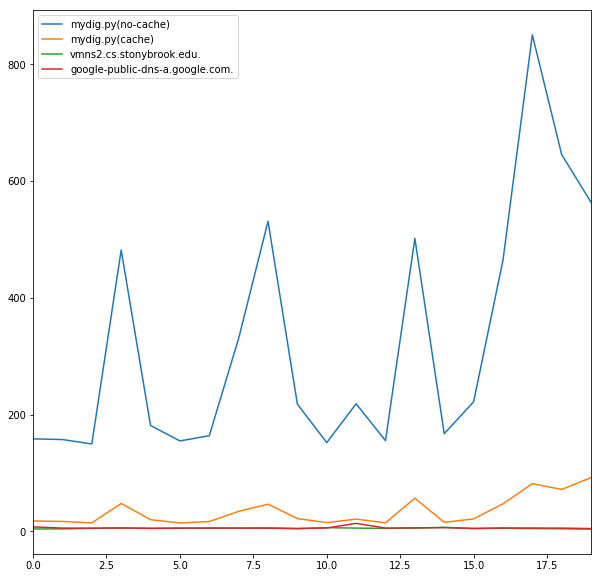

In [321]:
df_performance.plot(figsize=(10,10))

In [356]:
mylist = df_performance['mydig.py(no-cache)'].tolist()

In [358]:
def cdf_values(mylist):
    '''Calculate the values of a CDF, given an arbitrary list of numbers.
    
    Args:
        mylist (list): an arbitrary list of numbers
        
    Returns:
        X, Y (list, list): the corresponding X and Y values of a CDF
    '''
    mylist.sort()
    
    low = int(mylist[0])
    high = int(mylist[19]) + 1
    
    X = []
    Y = []
    y_sum = 0
    y_step = 1.0/len(mylist)
    mylist_i = 0
    
    for i in range(low, high+1):
        #print('i', i)
        X.append(i)
        while mylist[mylist_i] < i:
            #print('mylist_i', mylist_i)
            y_sum = y_sum + y_step
            mylist_i = mylist_i + 1
            if mylist_i > 19:
                break
        Y.append(y_sum)
    return X, Y

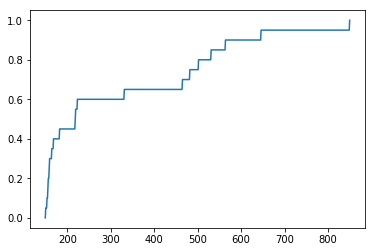

In [364]:
mylist = df_performance['mydig.py(no-cache)'].tolist()
X_mydig, Y_mydig = cdf_values(mylist)
plt.plot(X_mydig, Y_mydig)

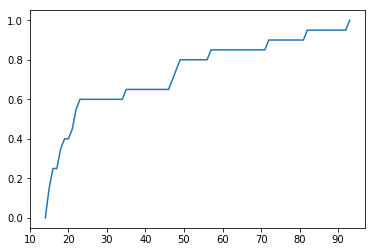

In [365]:
mylist = df_performance['mydig.py(cache)'].tolist()
X_mydig_cache, Y_mydig_cache = cdf_values(mylist)
plt.plot(X_mydig_cache, Y_mydig_cache)

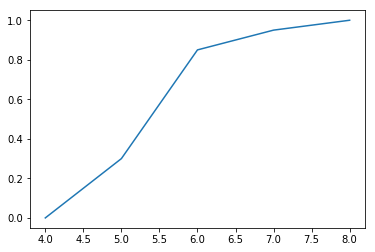

In [368]:
mylist = df_performance['vmns2.cs.stonybrook.edu.'].tolist()
X_cs, Y_cs = cdf_values(mylist)
plt.plot(X_cs, Y_cs)

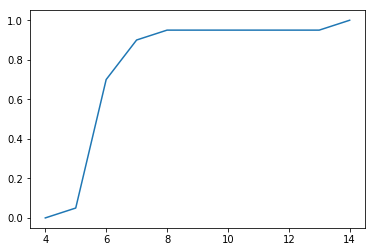

In [370]:
mylist = df_performance['google-public-dns-a.google.com.'].tolist()
X_google, Y_google = cdf_values(mylist)
plt.plot(X_google, Y_google)

([<matplotlib.axis.YTick at 0x120a2b080>,
 <a list of 11 Text yticklabel objects>)

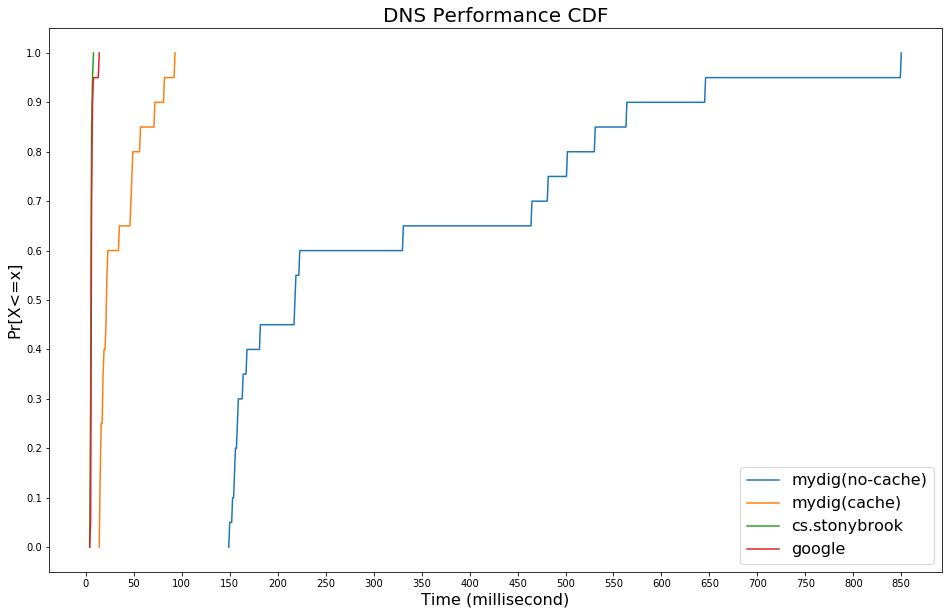

In [401]:
plt.figure(figsize=(16,10))
plt.plot(X_mydig, Y_mydig)
plt.plot(X_mydig_cache, Y_mydig_cache)
plt.plot(X_cs, Y_cs)
plt.plot(X_google, Y_google)
plt.legend(['mydig(no-cache)', 'mydig(cache)', 'cs.stonybrook', 'google'], prop={'size': 16})
plt.xlabel('Time (millisecond)', fontsize=16)
plt.ylabel('Pr[X<=x]', fontsize=16)
plt.title('DNS Performance CDF', fontsize=20)
x_axis = np.arange(0, 900, 50)
plt.xticks(x_axis)
y_axis = np.arange(0, 1.1, 0.1)
plt.yticks(y_axis)